# Leaky cavity 2-point binned correlation

Pierre Guilmin, 11/2022

In [1]:
import QuantumOptics as qo
using Statistics
using Plots
using LaTeXStrings

Plots.gr()
default(fontfamily="Computer Modern", framestyle=:grid, bottom_margin=4Plots.mm, left_margin=4Plots.mm, format=:png)
scalefontsizes(1.3)

include("binned-theory.jl")
include("smesolve.jl");

## The model

We introduce a toy model on which we compute the two-point correlation function of the signal which is integrated on constant overlapping windows, as in the paper. The code to compute the correlation is self-contained in the [`binned-theory.jl`](binned-theory.jl) script.

We consider a leaky cavity monitored with unit efficiency by a homodyne detector. The system Hamiltonian is $H = \Delta a^\dagger a$ and we have a single jump operator corresponding to one-photon loss of the cavity at a certain rate $\kappa$: $L = \sqrt{\kappa} a$.

The diffusive SME describing the evolution of the system is:
\begin{align*}
    \mathrm{d}t\rho_t &= -i[H,\rho_t]\mathrm{d}t + \mathcal{D}[L](\rho_t)\mathrm{d}t + \sqrt{\eta}\mathcal{M}[L](\rho_t)\mathrm{d}W_t\\
    &= -i[\Delta a^\dagger a,\rho_t]\mathrm{d}t + \mathcal{D}[\sqrt{\kappa}a](\rho_t)\mathrm{d}t + \sqrt{\eta}\mathcal{M}[\sqrt{\kappa}a](\rho_t)\mathrm{d}W_t
\end{align*}

And the signal is directly related to the average value of the $X=(a + a^\dagger)/2$ quadrature, $I_t=\mathrm{d}Y_t/dt$ with:
\begin{align*}
    \mathrm{d}Y_t &= \sqrt{\eta}\mathrm{Tr}\left[(L+L^\dagger)\rho_t\right]\mathrm{d}t + \mathrm{d}W_t\\
                  &= \sqrt{\eta}\mathrm{Tr}\left[(a+a^\dagger)\rho_t\right]\mathrm{d}t + \mathrm{d}W_t\\
                  &= 2\sqrt{\eta}\langle X\rangle_t\mathrm{d}t + \mathrm{d}W_t.
\end{align*}

Intuitively if we initialise the cavity in some coherent state $|\alpha\rangle$, it will spirale around the origin at a speed given by $\Delta$, and decay to the vacuum at a speed given by $\kappa$.

In [2]:
# physical parameters
delta = 1 * 2pi
alpha = 2
kappa = 0.8
eta = 1.0

# simulation parameters
N = 32
ntraj = 500
nbin = 1000
T = (2pi / delta) * 5  # 5 full rounds
Tbin = T / nbin
tlist = LinRange(0, T, nbin)

# operators
basis = qo.FockBasis(N - 1)
a = qo.destroy(basis)
adag = qo.dagger(a)

# initial state
rho0 = qo.dm(qo.coherentstate(basis, alpha))

# model
H = delta * adag * a
L = sqrt(kappa) * a;

## Semiclassical dynamic

We can quickly compute the semiclassical model as a baseline:

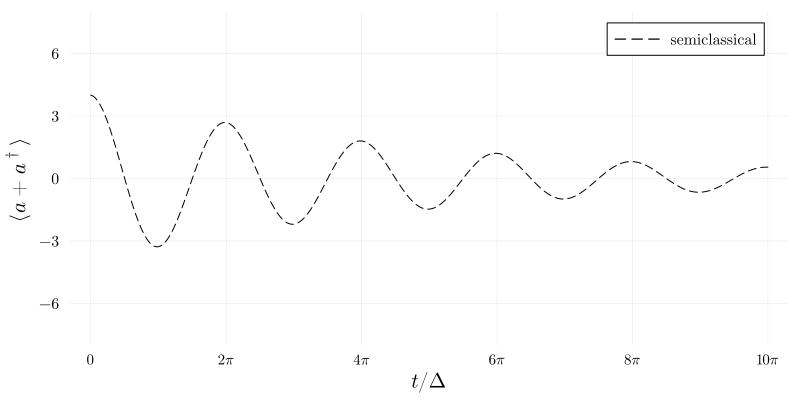

In [3]:
x_semc(t) = real(exp(-1im * delta * t) * alpha^2 * exp(-kappa / 2 * t))
x_sc = x_semc.(tlist)

p = plot(
    tlist, x_sc, label="semiclassical", color="black", style=:dash,
    xlabel=L"t/\Delta", ylabel=L"\langle a + a^\dagger \rangle",
    xticks=(0:1:5, [L"0", L"2\pi", L"4\pi", L"6\pi", L"8\pi", L"10\pi"]),
    size=(800, 400),
    ylim=(-8,8)
)

## Lindblad master equation evolution

We use `QuantumOptics.jl` to solve the deterministic Lindblad master equation, which is superimposed on the semiclassical dynamic:

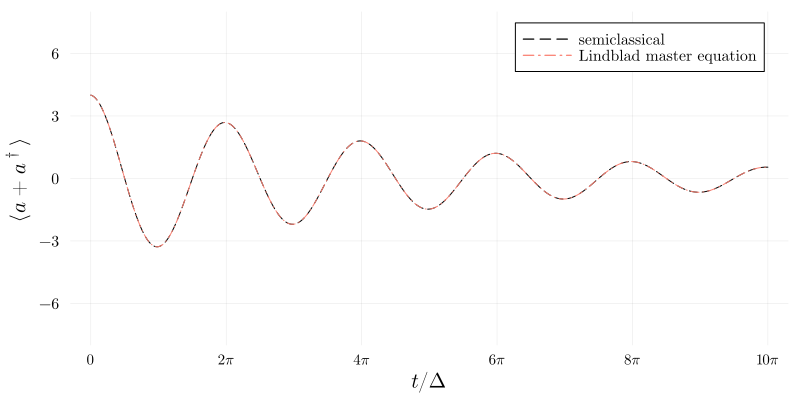

In [4]:
states = qo.timeevolution.master(tlist, rho0, H, [L])[2]
x_lind = real.(qo.expect(a + adag, states))
plot!(p, tlist, x_lind, label="Lindblad master equation", style=:dashdot, color="salmon")

## Simulating multiple quantum trajectories using the SME

The function `smesolve` is used to run multiple trajectories of the SME:

In [5]:
empty = Vector{Matrix{ComplexF64}}(undef, 0)
# ~ 5 min for 500 trajectories
ys = smesolve(H.data, empty, [L.data], [eta], rho0.data, T=T, Tbin=Tbin, dt=Tbin/10, ntraj=ntraj)[:, 1, :]
size(ys)  # (ntraj, nbin)

Progress: 100%|█████████████████████████████████████████| Time: 0:05:35


(500, 1000)

Let's plot one of the trajectories:

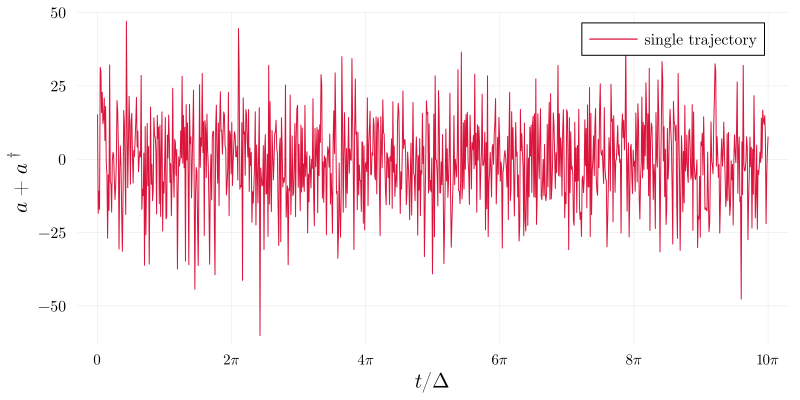

In [6]:
# plot a single trajectory
trajectory = ys[1, :]
plot(
    tlist, trajectory, label="single trajectory", color="crimson",
    xlabel=L"t/\Delta", ylabel=L"a + a^\dagger",
    xticks=(0:1:5, [L"0", L"2\pi", L"4\pi", L"6\pi", L"8\pi", L"10\pi"]),
    size=(800, 400),
)

We see that the average trajectory is close from the deterministic evolution given by the Lindblad master equation:

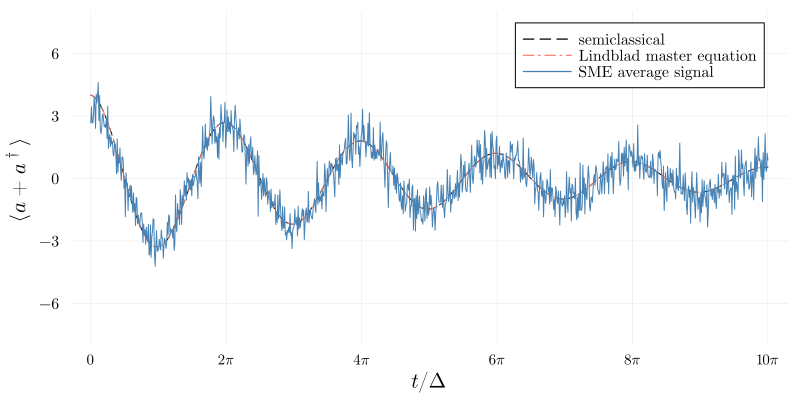

In [7]:
x_sme_mean = mean(ys, dims=1)[1, :]
plot!(p, tlist, x_sme_mean, label="SME average signal", color="steelblue")

## Overlapping windows two-point correlation function

Now we choose two time windows $\Omega_1$ and $\Omega_2$:

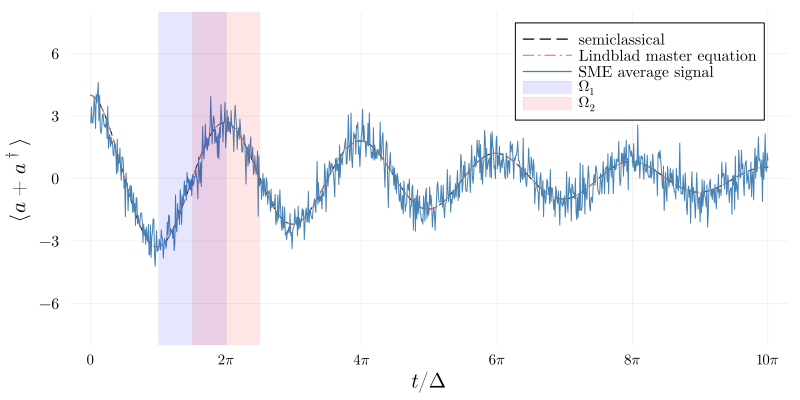

In [8]:
O1 = [0.5, 1]
O2 = [0.75, 1.25]
vspan!(p, O1, label=L"\Omega_1", opacity=.1, color="blue")
vspan!(p, O2, label=L"\Omega_2", opacity=.1, color="red")

In [9]:
plot!(p, dpi=300)
savefig("leaky-cavity.svg")
savefig("leaky-cavity.png");

Let's compute the two-point correlation function by averaging the correlation over the multiple simulated trajectories:

In [10]:
a, b = floor.(Int, O1 / Tbin)
c, d = floor.(Int, O2 / Tbin)
correlations = (sum(ys[:, a:b], dims=2) * Tbin .* sum(ys[:, c:d], dims=2) * Tbin)[:, 1]
mean(correlations)

0.18750109705731044

Note that many more trajectories would be needed to have an accurate estimation of the correlation. Now we can check what the theory gives using the [`binned-theory.jl`](binned-theory.jl) script (it runs instantly once compiled):

In [12]:
O1 = [0.5, 1]
O2 = [0.75, 1.25]
binned_theory(H.data, [L.data], 1, eta, rho0.data, Tuple(O1), Tuple(O2))

0.20892223636951593